In [1]:
### import lib and helper functions

import numpy as np
from tqdm import tqdm
import torch
import torch.nn as nn
from einops import rearrange, repeat, reduce
import os
import yaml, shutil

import wandb
from torch.utils.data import DataLoader
from weather_transformer import CaFAEPD
from dynamics_training_loop import configure_epd_models, configure_train_dataset_and_loader, configure_residual_stat, epd_predict
from utils.loss_utils import latitude_weighted_rmse
from utils.training_utils import dict2namespace
import gc
import xarray as xr
from datetime import datetime,timedelta                                                                                                                                 

In [ ]:
### set the device， it is recommended to use GPU
device = 'cuda:0'

### load the config which was used to train the model
with open('configs/era5-EPD-6432-stage2.yml', 'r') as f:
    config = yaml.safe_load(f)
config = dict2namespace(config)
model = configure_epd_models(config)    # load model


### load checkpoint, change the ckpt path correspondingly
ckpt_path = 'experiments/pretrained_ckpt/ema_last_6432.pth'
model.load_state_dict(torch.load(ckpt_path)['model'])
model.to(device)
model.eval()
print('loaded successfully')

In [ ]:
### prepare dataset's normalization statistics
train_dataset, _ = configure_train_dataset_and_loader(2, 1, config)    # the train dataset is just used to get the normalization statistics
normalizer = train_dataset.datareader.normalizer

# get the constant feature
constant_names = config.data.constant_names
constants = torch.from_numpy(train_dataset.datareader.constants).float().unsqueeze(0)

### load residual normalizer, which is used to de-normalize output of the model
residual_normalizer = configure_residual_stat(config)
# to device
residual_normalizer = residual_normalizer.to(device) 


In [4]:
### fetch data point from xarray dataset of WeatherBench 2
def fetch_and_process(dat_path,
                      init_time_coord,     # datetime of the initial condition
                      ):
    ds = xr.open_zarr(dat_path)
    # a slice of time coords
    time_coord = slice(init_time_coord, init_time_coord + timedelta(hours=6)*28)   # hardcode the forecast length to a week
    ds = ds.sel(time=time_coord)   # select the initial condition

    variable_groups = config.data.variable_groups
    # flatten the variable groups
    feature_names = [item for sublist in variable_groups for item in sublist]

    # get the data by variable name
    input_feat_dict = {}
    out_feat_dict = {}
    for var_name in feature_names:
        # transpose the latitude and longitude
        feat = ds[var_name].values
        if len(feat.shape) == 4:  # t, levels, nlon, nlat -> t, nlat, nlon, levels
            feat = np.transpose(feat, (0, 3, 2, 1))
        elif len(feat.shape) == 3:  # t, nlon, nlat -> t, nlat, nlon
            feat = np.transpose(feat, (0, 2, 1))

        input_feat_dict[var_name] = torch.from_numpy(feat[0]).float().unsqueeze(0)   # only use the first time step as input
        out_feat_dict[var_name] = torch.from_numpy(feat[1:]).float().unsqueeze(0) 

    return input_feat_dict, out_feat_dict


In [5]:
### try prediction on 2018-01-01 00:00:00
init_time = datetime(2018, 1, 1, 0, 0, 0)
### change to the path of the xr dataset
dat_path = '/home/cmu-mail-3090/Zijie_2/pde_data/1959-2022-6h-64x32_equiangular_with_poles_conservative.zarr'
### get the input and output features
input_dict, target_dict = fetch_and_process(dat_path, init_time)

In [6]:
target_dict['2m_temperature'].shape

torch.Size([1, 28, 32, 64])

In [7]:
### use epd_predict to predict the output
with torch.no_grad():
    torch.cuda.empty_cache()
    loss_dict, pred_dict = epd_predict(model, [1, 4, 12, 20, 28], input_dict, target_dict, constants,
                                    normalizer,
                                    residual_normalizer,
                                    latitude_weighted_rmse,
                                    config=config,
                                    device=device,
                                    return_pred=True)

In [8]:
### checkout the loss at different lead time: 6hr 1day 3day 5day 7day
loss_dict['2m_temperature']

tensor([[0.3263, 0.5097, 0.8088, 1.2526, 1.8833]], device='cuda:0',
       dtype=torch.float64)

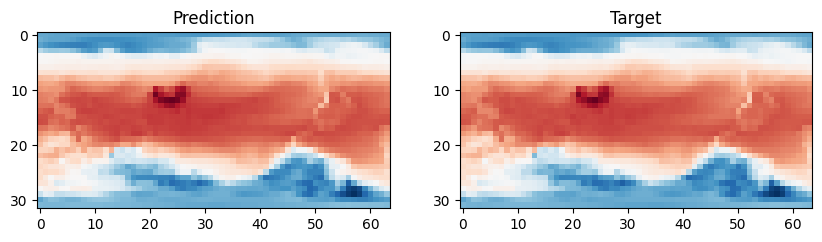

In [9]:
### visualize the prediction and target
from matplotlib import pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# prediction
axs[0].imshow(pred_dict['2m_temperature'][0, 0].cpu().numpy(), cmap='RdBu_r')
axs[0].set_title('Prediction')
# target
axs[1].imshow(target_dict['2m_temperature'][0, 0].cpu().numpy(), cmap='RdBu_r')
axs[1].set_title('Target')
plt.show()
